## Running hyperparameter optimization - Part 2

This notebook goes through part two of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies using in <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i>. From those results the optimal combination are then tested for stability of the latent space in repeated training using this notebook.

In [1]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

from move._utils.data_utils import get_data, get_list_value, merge_configs
from move._utils.visualization_utils import draw_boxplot
from move._training.train import optimize_stability
from move._analysis.analysis import get_top10_stability, calculate_latent

/home/valentas/move2/MOVE/src/move/training/train.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf", config_name="main")


Below are the funcitons for reading data and calculations defiend

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

For this part we use all the data contraty to part 1 where it was divided into trainig and test, and investigate how similar the latent space is between the repeated runs. Below we define the selected hyper-parameter settings with equal or close to equal performance based on part 1. For plotting purposes we only test on three different "types" here being size of the hidden layer (nHidden), size of the latent space (nLatents) and the drop-out (drop_outs). The number of hidden lasyers are set to 1 (nl=1). We here repeat the traininng 5 times. 

In [2]:
from omegaconf import OmegaConf
from collections import defaultdict


In [3]:


def get_best_paramset(stability_df, hyperparams_names):
    params_to_save = dict()
    
    stability_df_sorted = stability_df.sort_values('difference', ascending=False).iloc[:1]
    for hyperparam in hyperparams_names: 
        params_to_save[hyperparam] = stability_df_sorted[hyperparam].item()
#     params_to_save = dict(params_to_save)
    return(params_to_save, stability_df_sorted)

# params_to_save = get_best_paramset(stability_top10_df, hyperparams_names)

In [4]:
# print(results_df_sorted)
def get_best_4_latent_spaces(results_df_sorted):
    best_latent = []
    for index, row in results_df_sorted.iterrows():
        if row['num_latent'] not in best_latent:
            best_latent.append(int(row['num_latent']))
        if len(best_latent) >= 2:
            break
            
    #Adding two values from both sides 
    best_hypers_diff = max(best_latent) - min(best_latent)
    diff_from_zero = int(min(best_latent)/2)
    
    if min(best_latent) - best_hypers_diff > diff_from_zero:
        best_latent.append(min(best_latent) - best_hypers_diff)
        best_latent.append(max(best_latent) + best_hypers_diff)
    else:
        best_latent.append(min(best_latent) - diff_from_zero)
        best_latent.append(max(best_latent) + diff_from_zero)
    return(best_latent)

# best_latent = get_best_4_latent_spaces(results_df_sorted)
# print(best_latent)

#todo print: select manually. 150;200;250,300


Configuration used: 
---
data:
  user_config: data.yaml
  na_value: 'nan'
  raw_data_path: data/
  interim_data_path: data/
  processed_data_path: data/
  version: v1
  ids_file_name: baseline_ids
  categorical_inputs:
  - name: diabetes_genotypes
    weight: 1
  - name: baseline_drugs
    weight: 1
  - name: baseline_categorical
    weight: 1
  continuous_inputs:
  - name: baseline_continuous
    weight: 2
  - name: baseline_transcriptomics
    weight: 1
  - name: baseline_diet_wearables
    weight: 1
  - name: baseline_proteomic_antibodies
    weight: 1
  - name: baseline_target_metabolomics
    weight: 1
  - name: baseline_untarget_metabolomics
    weight: 1
  - name: baseline_metagenomics
    weight: 1
  data_of_interest: baseline_drugs
  categorical_names: ${names:${data.categorical_inputs}}
  continuous_names: ${names:${data.continuous_inputs}}
  categorical_weights: ${weights:${data.categorical_inputs}}
  continuous_weights: ${weights:${data.continuous_inputs}}
model:
  user_co

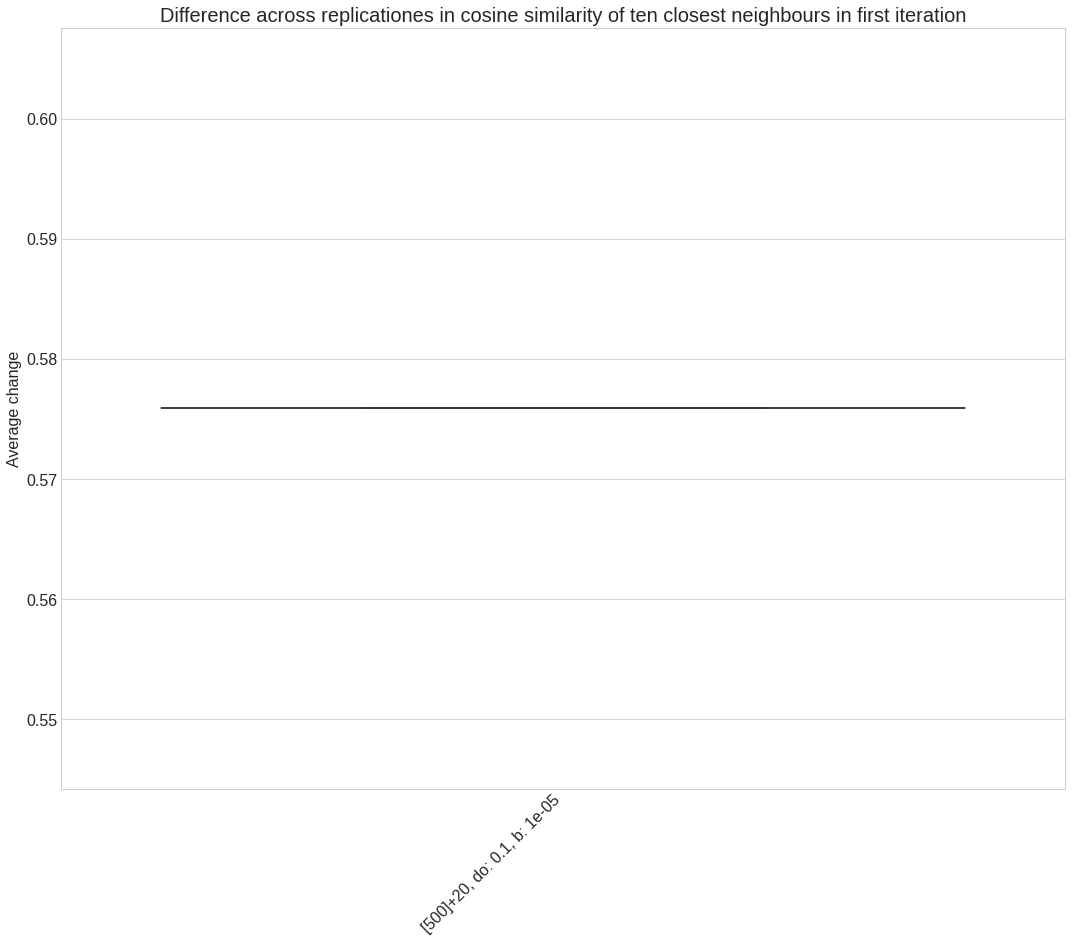

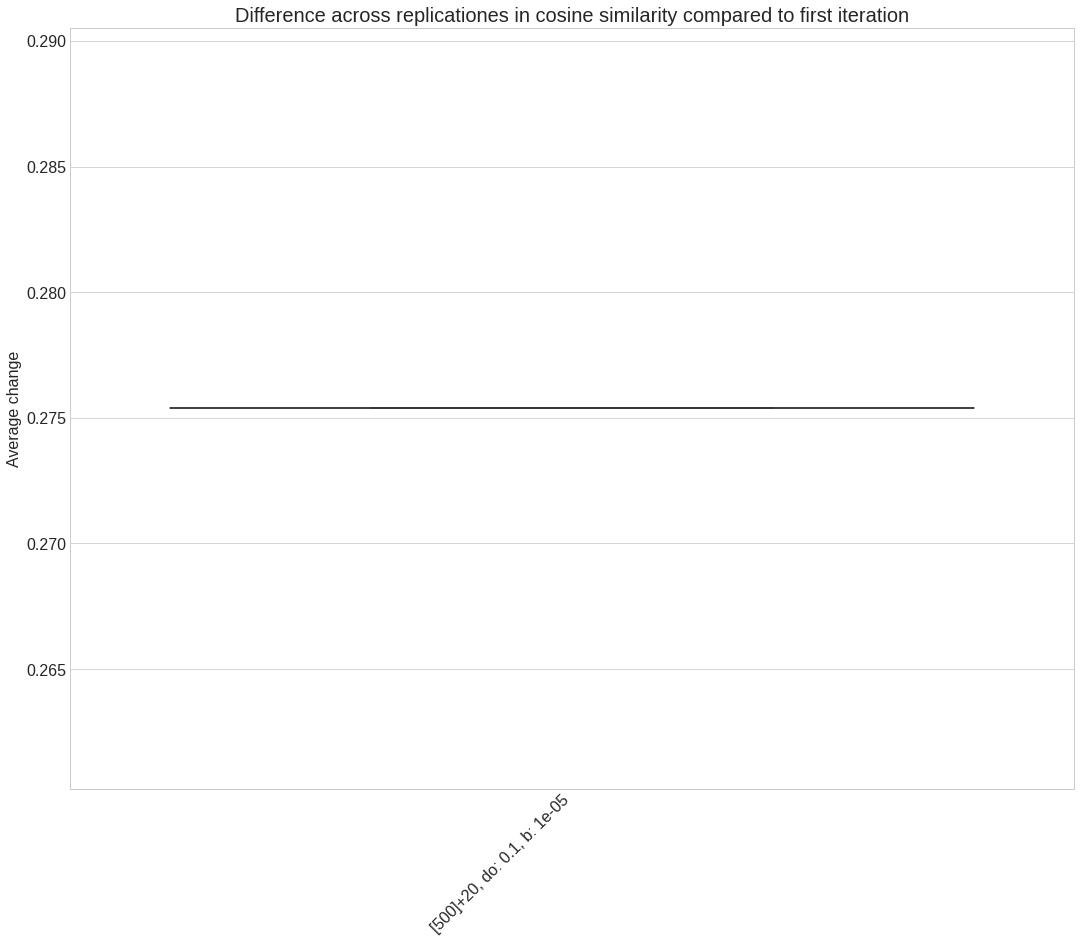

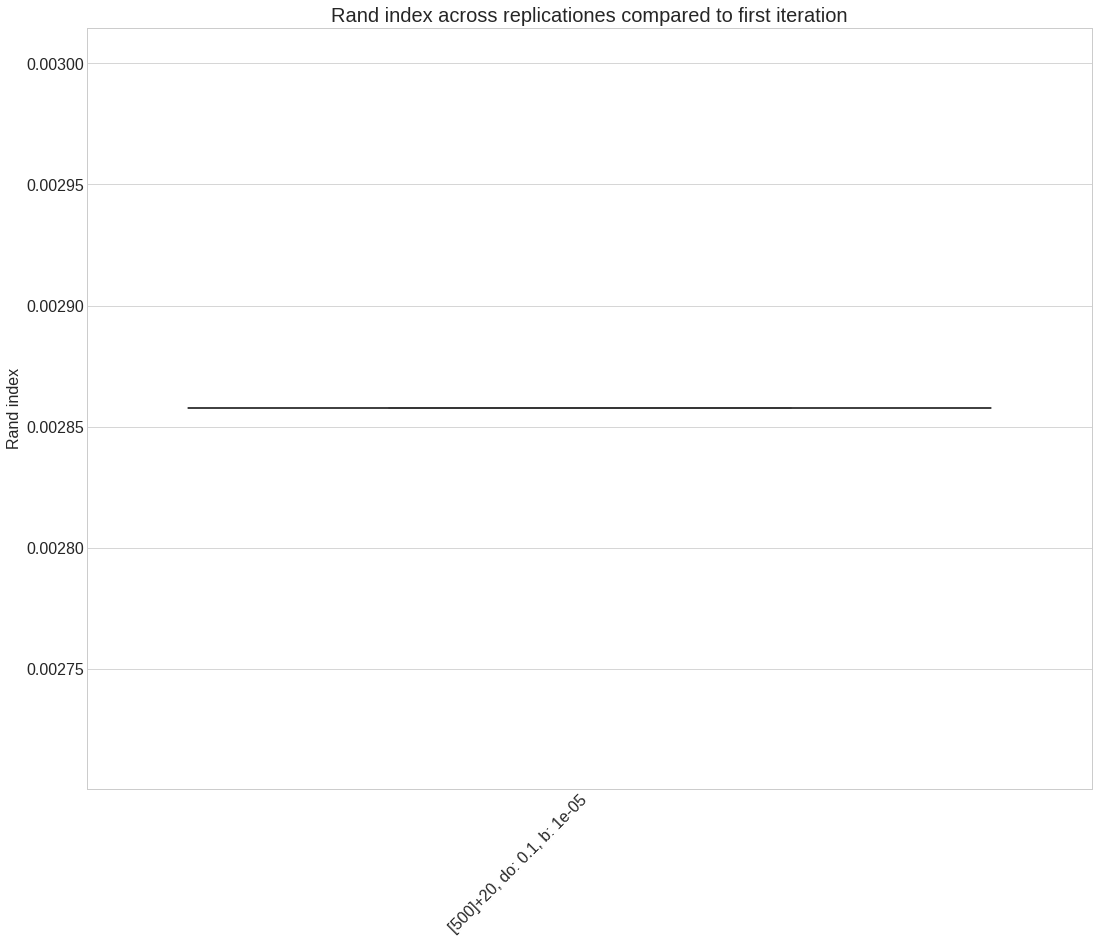

In [5]:
with initialize(version_base=None, config_path="src/move/conf"):
    base_config = compose(config_name="main")
    
def main(base_config=base_config): 
    cfg = merge_configs(base_config=base_config, 
                        config_types=['data', 'model', 'tuning_stability'])
    #Get needed variables
    path = cfg.data.processed_data_path   
    data_of_interest = cfg.data.data_of_interest
    categorical_names = cfg.data.categorical_names
    continuous_names = cfg.data.continuous_names
    categorical_weights = cfg.data.categorical_weights
    continuous_weights = cfg.data.continuous_weights
    
    cuda = cfg.model.cuda
    lrate = cfg.model.lrate
    kld_steps = cfg.model.kld_steps
    batch_steps = cfg.model.batch_steps
    
    nHiddens = cfg.tuning_stability.num_hidden
    nLatents = cfg.tuning_stability.num_latent
    nLayers = cfg.tuning_stability.num_layers
    nDropout = cfg.tuning_stability.dropout
    nBeta = cfg.tuning_stability.beta
    batch_sizes = cfg.tuning_stability.batch_sizes
    repeat = cfg.tuning_stability.repeats
    nepochs = cfg.tuning_stability.tuned_num_epochs
    
    # Todo: clean these lines of code
    if len(batch_sizes)==1:
        batch_sizes = batch_sizes[0]
    elif len(batch_sizes)>1:
        raise('Currently the code is implemented to take take only one value for batch_size')
    
#     nBeta = nBeta[0]
#     nLatents = nLatents[0]

#     print(nHiddens, nLatents, nDropout, nBeta, repeat, nepochs, nLayers, batch_sizes)
    
    #Get the data
    cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(path, categorical_names, continuous_names, data_of_interest)

    
    embeddings, latents, con_recons, cat_recons, recon_acc = optimize_stability(nHiddens, nLatents, 
                                                                                nDropout, nBeta, repeat,
                                                                                nepochs, nLayers,
                                                                                batch_sizes, lrate, 
                                                                                kld_steps, batch_steps, 
                                                                                cuda, path, 
                                                                                con_list, cat_list,
                                                                                continuous_weights, categorical_weights)
    
    stability_top10, stability_top10_df = get_top10_stability(nHiddens, nLatents, nDropout, nLayers, repeat, latents, batch_sizes, nBeta)
    
    stability_total, rand_index = calculate_latent(nHiddens, nLatents, nDropout, repeat, nLayers, nBeta, latents) # Todo add priting or smth
    
    draw_boxplot(path=path,
                 df=stability_top10,
                 title_text='Difference across replicationes in cosine similarity of ten closest neighbours in first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_top10")
    
    draw_boxplot(path=path,
                 df=stability_total,
                 title_text='Difference across replicationes in cosine similarity compared to first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_all")
    
    draw_boxplot(path=path,
                 df=rand_index,
                 title_text='Rand index across replicationes compared to first iteration',
                 y_label_text="Rand index",
                 save_fig_name="rand_index_all")
    
    
    # Getting best set of hyperparameters
    hyperparams_names = ['num_hidden', 'num_latent', 'num_layers', 'dropout', 'beta', 'batch_sizes']
    params_to_save, stability_top10_df_sorted = get_best_paramset(stability_top10_df, hyperparams_names)
    params_to_save['tuned_num_epochs'] = nepochs

    # Saving best set of hyperparameters    
    with open('training_latent.yaml', "w") as f:
        OmegaConf.save(OmegaConf.create(dict(params_to_save)), f)
        
    # Printing the configuration saved 
    print(f'Saving parameters in training_latent.yaml: \n {OmegaConf.to_yaml(dict(params_to_save))}')
    
    # Getting the latent spaces for training_association script and using them with the best hyperparam set
    best_latent = get_best_4_latent_spaces(stability_top10_df_sorted)
    params_to_save['num_latent'] = list(best_latent)
    
    # Saving best set of hyperparameters for training_association script
    with open('training_association.yaml', "w") as f:
        OmegaConf.save(OmegaConf.create(dict(params_to_save)), f)

    # Printing the configuration saved 
    print(f'Saving parameters in training_association.yaml: \n {OmegaConf.to_yaml(dict(params_to_save))}')
    
    return()
    
if __name__ == "__main__":
    main()


Below we run the full grid search. Here we also save the UMAP embeddings for the posibility of a visual investigation of the results.

Below is calcualtion and visualisation only focusig on the top 10 closest neigbour for each individual

The next part compared based on all of the latent space. Furthermore, it includes code for calculation on cluster stability if the latent space is to be used for clustering (not used by MOVE in the paper here only cosine similarity on latent is included).

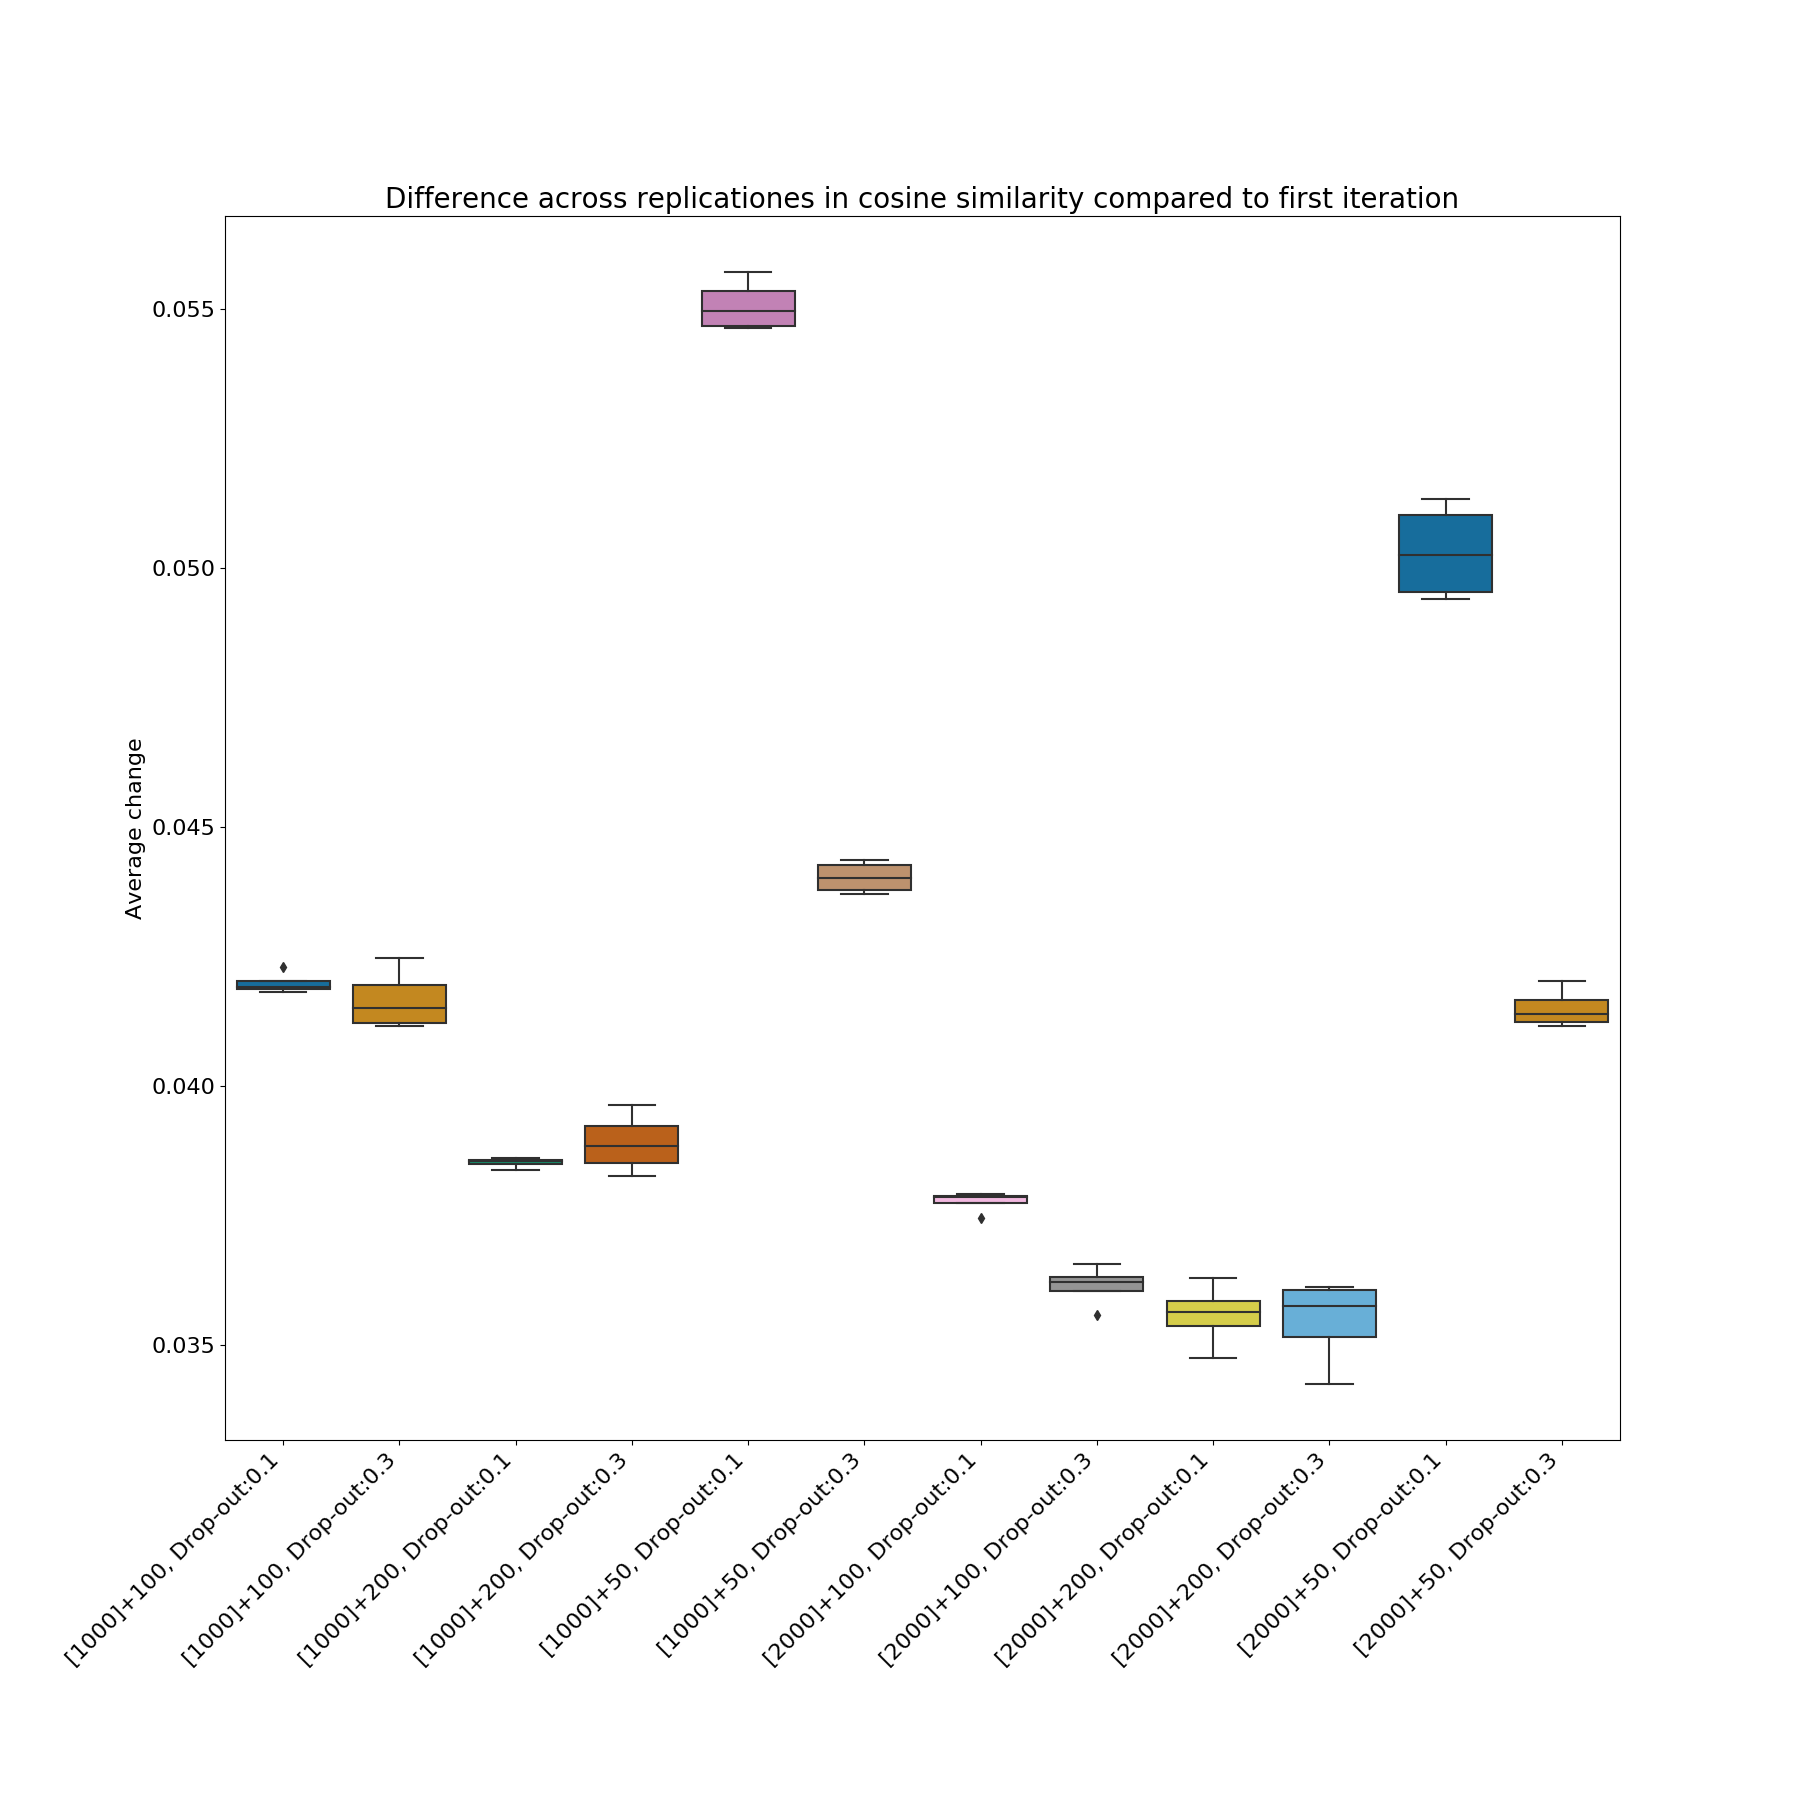

From here on the optimal setting for further analysis can be selected. This includes the framework used in MOVE for identifying drug and multi-omics assosiations as descriped in the notebook <i>identify_drug_assosiation.ipynb</i>, compare the latent space integration to other methods (PCA) using the notebook <i>latent_space_analysis.ipynb</i> or for other types of analysis such as clustering of the latent space (not included here). 